# Proces oraz wizualizacja tworzenia modelu klasyfikującego zdarzenia dźwiękowe w środowisku domowym
Autorzy
- Julia Jelska
- Piotr Muzyka
- Paweł Niewiarowski

# Cel projektu
Celem tego projektu jest zbudowanie modelu uczenia maszynowego, który potrafi rozpoznawać i klasyfikować różne zdarzenia dźwiękowe nagrywane w warunkach domowych. \
Proces obejmuje kilka kluczowych etapów:
- **Przygotowanie danych** – nagrania dźwięków pochodzące z konkretnych, predefiniowanych klas (np. dzwonek, odkurzacz, pukanie do drzwi) są oczyszczane i segmentowane na próbki odpowiednie do analizy.
- **Ekstrakcja cech** – z nagrań wyodrębniamy istotne cechy sygnału, takie jak MFCC, energia, chroma czy spektrum częstotliwości, które umożliwiają modelowi rozróżnianie klas.
- **Budowa modelu** – na podstawie przygotowanych danych trenujemy klasyfikator (np. Random Forest, SVM lub sieć neuronową), który uczy się rozpoznawać konkretne zdarzenia dźwiękowe.
- **Wizualizacja wyników** – wyniki klasyfikacji prezentujemy w postaci macierzy pomyłek, krzywej uczenia oraz innych wykresów, co pozwala lepiej zrozumieć działanie modelu i zidentyfikować klasy sprawiające największą trudność.

# Wykorzystane zależności
- [librosa](https://librosa.org/)
- [numpy](https://numpy.org/)
- [sklearn](https://scikit-learn.org/)

In [25]:
import os
import librosa
import numpy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, learning_curve, KFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_predict


## Załadowanie danych z systemu plików
Załadowanie d danych testowych oraz trenig

In [26]:
DATA_DIR: str = '../../dataset/'

In [27]:
labels: list = []
features: list = []

In [28]:
# --- NOWA EKSTRAKCJA CECH (52 parametry) ---
# 13 MFCC x (Mean + Std + Delta Mean + Delta Std)

labels = []
features = []

# Upewniamy się, że ścieżka jest poprawna (zdefiniowana w poprzednich komórkach)
print(f"Pobieranie danych z: {DATA_DIR}")

for label in os.listdir(DATA_DIR):
    class_dir = os.path.join(DATA_DIR, label)
    
    if not os.path.isdir(class_dir):
        continue
        
    print(f"Przetwarzanie klasy: {label}...")
    
    for filename in os.listdir(class_dir):
        if filename.endswith(".wav"):
            file_path = os.path.join(class_dir, filename)
            
            try:
                # Wczytanie pliku
                y, sr = librosa.load(file_path, sr=None)
                
                # 1. Obliczamy MFCC (13 współczynników - standard dla mowy/dźwięków)
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                
                # 2. Obliczamy Delta (dynamika zmian)
                mfcc_delta = librosa.feature.delta(mfcc)
                
                # --- AGREGACJA STATYSTYK ---
                
                # A. Statystyki dla samych MFCC (Barwa + Zmienność)
                mfcc_mean = numpy.mean(mfcc, axis=1) # 13 cech
                mfcc_std = numpy.std(mfcc, axis=1)   # 13 cech
                
                # B. Statystyki dla Delt (Tempo zmian + Zmienność tempa)
                delta_mean = numpy.mean(mfcc_delta, axis=1) # 13 cech
                delta_std = numpy.std(mfcc_delta, axis=1)   # 13 cech
                
                # Łączymy w wektor 52-elementowy
                combined_features = numpy.concatenate((mfcc_mean, mfcc_std, delta_mean, delta_std))
                
                features.append(combined_features)
                labels.append(label)
                
            except Exception as e:
                print(f"Błąd przy pliku {filename}: {e}")

# Konwersja na numpy array
features_xs = numpy.array(features)
labels_ys = numpy.array(labels)

print(f"\nZakończono ekstrakcję. Wymiar macierzy cech: {features_xs.shape}")
# Oczekiwany wynik: (158, 52)

Pobieranie danych z: ../../dataset/
Przetwarzanie klasy: doorbell...


/home/muzykos-laptop/Documents/GIThub/jupyterenv/lib/python3.13/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Przetwarzanie klasy: vacuum_cleaner...
Przetwarzanie klasy: door_knock...

Zakończono ekstrakcję. Wymiar macierzy cech: (158, 52)


In [29]:
features_xs = numpy.array(features)
labels_ys = numpy.array(labels)

Rozpoczynam walidację krzyżową...
Wyniki CV (5-fold): [0.95238095 1.         0.95238095 0.95238095 0.9047619 ]
Średnia dokładność (CV): 95.24% (+/- 3.01%)

Dokładność na zbiorze testowym (Hold-out): 100.00%


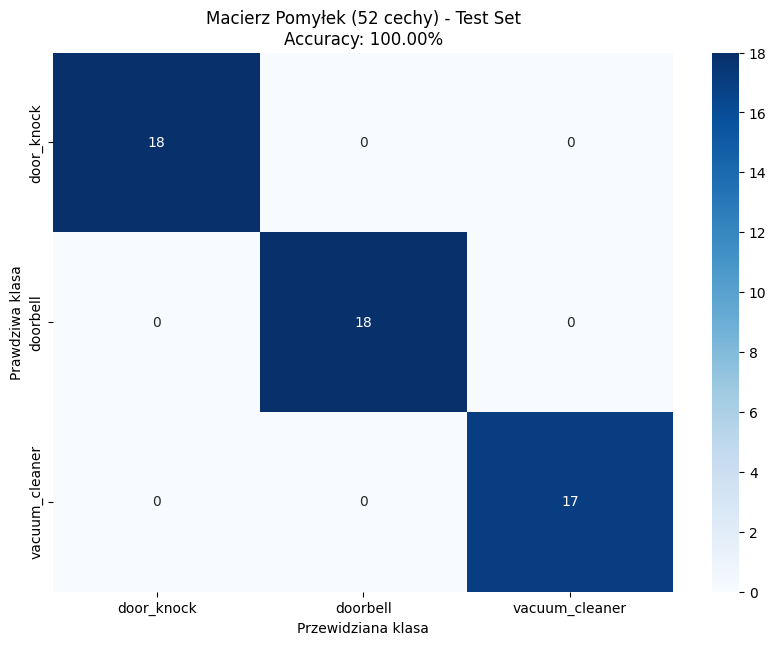

In [30]:
# --- PRZYGOTOWANIE DANYCH I TRENING (PIPELINE) ---

# 1. Encodowanie etykiet (zamiana nazw na liczby)
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(labels_ys)

# 2. Podział na zbiór treningowy i testowy (Stratified zapewnia równe proporcje klas)
x_train, x_test, y_train, y_test = train_test_split(
    features_xs, y_enc, test_size=1/3, random_state=42, stratify=y_enc
)

# 3. Tworzymy Pipeline: Skalowanie + SVM
# Pipeline automatycznie pilnuje, żeby nie było wycieku danych przy walidacji krzyżowej
clf_pipeline = make_pipeline(
    StandardScaler(), 
    SVC(kernel="rbf", C=1.0, probability=True, random_state=42)
)

# 4. Trening i Walidacja Krzyżowa (5-fold) na zbiorze treningowym
print("Rozpoczynam walidację krzyżową...")
cv_scores = cross_val_score(clf_pipeline, x_train, y_train, cv=5, scoring='accuracy')

print(f"Wyniki CV (5-fold): {cv_scores}")
print(f"Średnia dokładność (CV): {cv_scores.mean():.2%} (+/- {cv_scores.std():.2%})")

# 5. Finalny trening na całym zbiorze treningowym
clf_pipeline.fit(x_train, y_train)

# 6. Sprawdzenie na zbiorze testowym (ostateczna weryfikacja)
y_pred = clf_pipeline.predict(x_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"\nDokładność na zbiorze testowym (Hold-out): {test_acc:.2%}")

# --- WIZUALIZACJA MACIERZY POMYŁEK ---
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title(f"Macierz Pomyłek (52 cechy) - Test Set\nAccuracy: {test_acc:.2%}")
plt.ylabel("Prawdziwa klasa")
plt.xlabel("Przewidziana klasa")
plt.show()

## Klasyfikator SVM

### Parametry konfiguracji klasyfikatora SVM
- **C**: określa jak mocno model karze błędy; im większe C, tym bardziej model dąży do idealnego dopasowania
- **kernel**: rodzaj funkcji jądra; RBF jest najpopularniejsze dla nieliniowych danych
- **degree**: ma znaczenie tylko dla jądra "poly", przy RBF jest ignorowane
- **gamma**: określa wpływ pojedynczego punktu na granicę decyzji; wartość "scale" oznacza automatyczne obliczenie
- **coef0**: używane tylko przy jądrach "poly" i "sigmoid"
- **shrinking**: czy używać heurystyki przyspieszającej obliczenia
- **probability**: umożliwia obliczanie prawdopodobieństw klas (predict_proba); spowalnia trenowanie
- **tol**: tolerancja błędu, przy której algorytm kończy iteracje
- **cache_size**: ilość pamięci (w MB) przeznaczona na cache jądra
- **class_weight**: pozwala ustawić różne wagi dla klas, np. "balanced" przy nierównych zbiorach
- **verbose**: włącza logowanie pracy algorytmu (głównie do debugowania)
- **max_iter**: maksymalna liczba iteracji treningu; -1 oznacza brak limitu
- **decision_function_shape**: sposób obsługi wielu klas: "ovr" (one-vs-rest) lub "ovo" (one-vs-one)
- **break_ties**: jeśli True, rozstrzyga remisy (działa tylko przy decision_function_shape="ovr")
- **random_state**: ustawia ziarno losowości, aby wyniki były powtarzalne

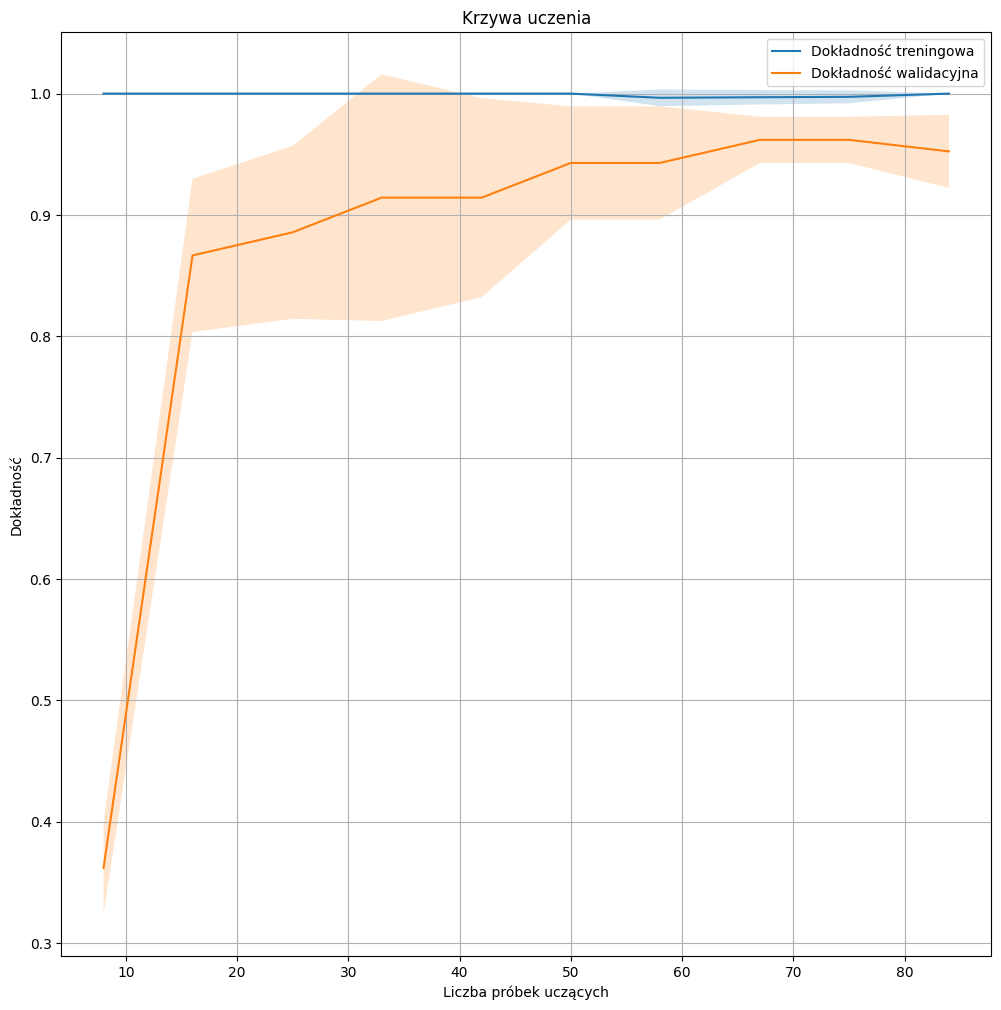

In [31]:
train_sizes, train_scores, val_scores = learning_curve(
    estimator=clf_pipeline,
    X=x_train,
    y=y_train,
    cv=5,
    train_sizes=numpy.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = numpy.mean(train_scores, axis=1)
train_std = numpy.std(train_scores, axis=1)
val_mean = numpy.mean(val_scores, axis=1)
val_std = numpy.std(val_scores, axis=1)

plt.figure(figsize=(12, 12))
plt.plot(train_sizes, train_mean, label="Dokładność treningowa")
plt.plot(train_sizes, val_mean, label="Dokładność walidacyjna")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.title("Krzywa uczenia")
plt.xlabel("Liczba próbek uczących")
plt.ylabel("Dokładność")
plt.legend()
plt.grid(True)
plt.show()

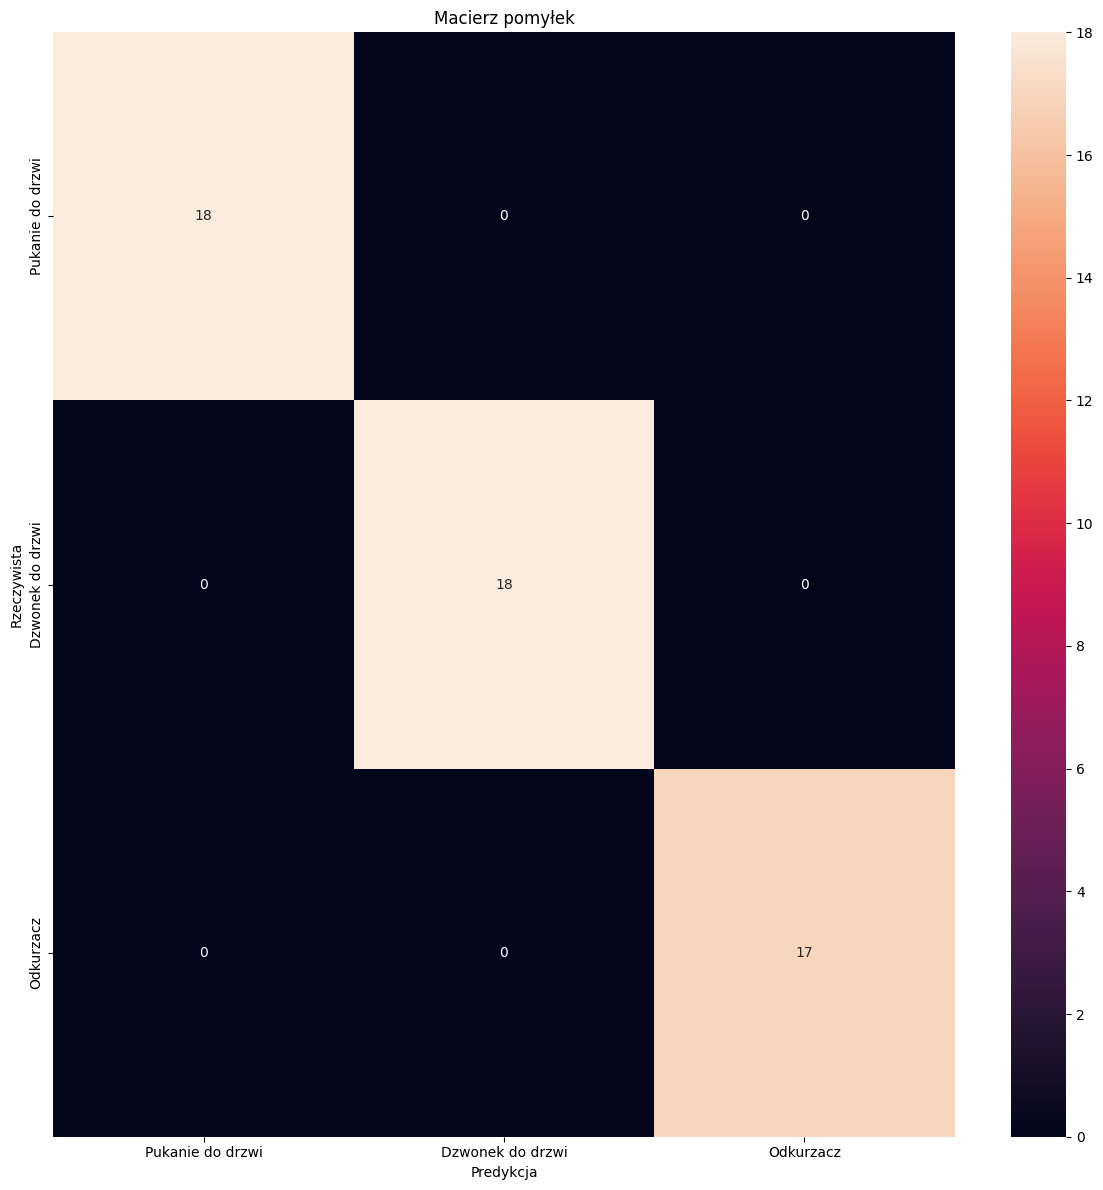

In [32]:
plt.figure(figsize=(12, 12))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt="d",
    xticklabels=["Pukanie do drzwi", "Dzwonek do drzwi", "Odkurzacz"],
    yticklabels=["Pukanie do drzwi", "Dzwonek do drzwi", "Odkurzacz"],
)

plt.xlabel("Predykcja")
plt.ylabel("Rzeczywista")
plt.title("Macierz pomyłek")
plt.tight_layout()
plt.show()

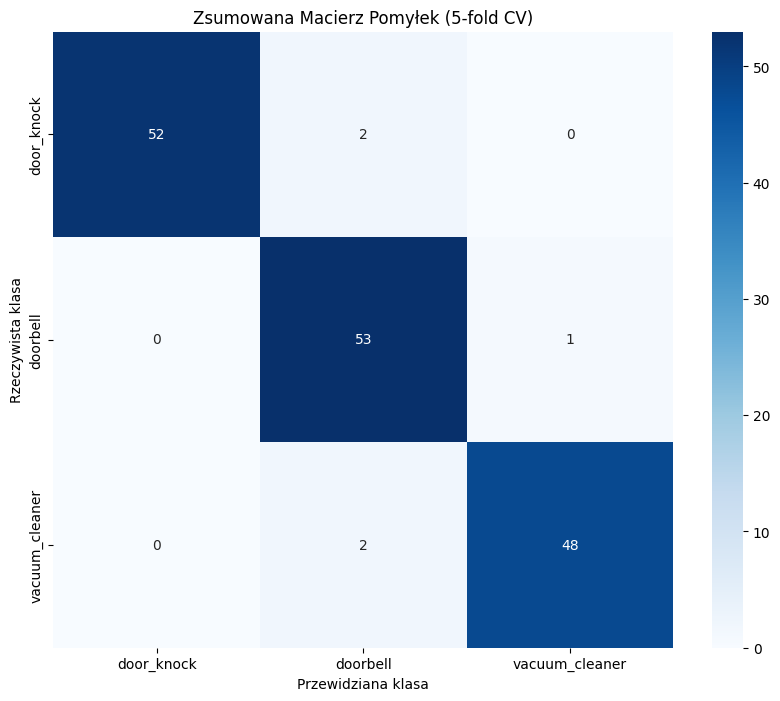

In [33]:
# 1. Definiujemy brakujące zmienne (K-Fold)
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# 2. Generujemy predykcje dla całego zbioru danych przy użyciu CV
# Używamy features_xs i y_enc (cały zbiór), pipeline sam zadba o skalowanie wewnątrz każdego foldu
y_pred_cv = cross_val_predict(clf_pipeline, features_xs, y_enc, cv=skf)

# 3. Wizualizacja Macierzy Pomyłek
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_enc, y_pred_cv)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_, # Pobieramy nazwy klas z encodera
    yticklabels=label_encoder.classes_
)

plt.xlabel("Przewidziana klasa")
plt.ylabel("Rzeczywista klasa")
plt.title(f"Zsumowana Macierz Pomyłek ({k_folds}-fold CV)")
plt.show()